# Data Augmentation

First, let's create our dataset using the one created in the previous section (`2.Custom-Dataset.ipynb`).

After that, we'll save the new images on a folder we're gonna call `augmented-dataset` so you can see the diference between the real `dataset` and the new images we've generated using data augmentation.

> It's important to keep in mind that the generated images after performing
> data augmentation should look similar to the images we'll introduce to our
> model doing inference.

> For example, if we want to create a dataset to detect people walking it does not
> make sense to flip the images vertically as the model will never see images
> of people walking that way!

Notice that, with torchvisin we perform the Normalize after converting the images ToTensor. However, in Albumentations we perform the Normalize transform before executing the transformation ToTensorV2.

In [21]:
import torch
from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader

import os
import pandas as pd
from skimage import io

In [22]:
class CatsAndDogsDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[idx, 0])
        image = io.imread(img_path)
        y_label = torch.tensor(int(self.annotations.iloc[idx, 1]))

        # These are gonna be the transformation we're going to apply
        # using data augmentation
        if self.transform:
            image = self.transform(image)
        
        return (image, y_label)

In [28]:
FOLDER_NAME='augmented-datasets'

In [29]:
if not os.path.exists(FOLDER_NAME):
    os.mkdir(FOLDER_NAME)

## Data Augmentation using Torchvision

In [24]:
# transformations we can perform on our dataset
import torchvision.transforms as transforms

Create the data augmentation transformations ([Click here to see the documentation](https://pytorch.org/vision/stable/transforms.html)):

`transforms.ToPILImage`: PyTorch applies the transformation to PIL images. So make sure you convert them in the __getitem__ magic method of the dataset or in the transformations.

`transforms.ToTensor()`: Once all the transformation have been applied, remember to convert the PIL Images into Tensors.

`transforms.Normalize(mean=[value, value, value], std=[value, value, value])`: It improves the results a little bit. Make sure you apply it after converting the images to tensors. You can find at the end of this section how to perform the calculations of the mean and the std.

In [51]:
my_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 256)),
    transforms.RandomCrop((224, 224)),
    transforms.ColorJitter(brightness=0.5),
    transforms.RandomRotation(degrees=45),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.05),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.5292, 0.4885, 0.4486], std=[0.0068, 0.0069, 0.0059]),
])

In [52]:
# we pass the transformations as an argument to the custom dataset
dataset = CatsAndDogsDataset('dataset/cats_dogs.csv', 'dataset/cats_dogs_resized', my_transforms)

Save the images after performing data augmentation on the folder `augmented-datasets`:

In [53]:
# As there are 10 images in our original dataset, doing this will create a dataset of
# 10*10 images
img_num = 0
for _ in range(10):
    for img, label in dataset:
        save_image(img, f'{FOLDER_NAME}/img{img_num}.png')
        img_num += 1

After you've seen the images, you can delete them to free space executing the following cell:

In [54]:
for file_name in os.listdir(FOLDER_NAME):
    os.remove(os.path.join(FOLDER_NAME, file_name))

#### Calculate the mean and the std

In [15]:
# To calculate the mean and the std, make sure you convert the images
# to tensors before by applying the transformation transforms.ToTensor()
dataset = CatsAndDogsDataset('dataset/cats_dogs.csv',
                             'dataset/cats_dogs_resized',
                             transform=transforms.ToTensor())

In [16]:
train_loader = DataLoader(dataset = dataset, batch_size=4, shuffle=True)

In [17]:
def get_mean_std(loader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0

    for data, _ in loader:
        channels_sum += torch.mean(data, dim=[0,2,3])
        channels_squared_sum += torch.mean(data**2, dim=[0,2,3])
        num_batches += 1
    
     # VAR[X] = E[X**2] - E[X]**2
    mean = channels_sum / num_batches
    std = (channels_squared_sum/num_batches - mean ** 2) ** 2

    return mean, std

In [20]:
mean, std = get_mean_std(train_loader)
print(f"Mean: {mean}", f"Std: {std}", sep="\n")

Mean: tensor([0.5292, 0.4885, 0.4486])
Std: tensor([0.0068, 0.0069, 0.0059])


If you're using the dataset downloaded with this repository, you should have got values similar to:
```
Mean: tensor([0.5292, 0.4885, 0.4486])
Std: tensor([0.0068, 0.0069, 0.0059])
```

## Data Augmentation using Albumentations

Albumentations is better than torchvision in data augmentation because:
- It's much faster than PyTorch in every benchmark.
- It has support of many more tasks than torchvision like segmentation and detection.

I encourage you to see the following tutorial:
[Migrating from torchvision to Albumentations](https://albumentations.ai/docs/examples/migrating_from_torchvision_to_albumentations/)

In [77]:
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

Visualization functions:

In [78]:
def visualize(image):
    plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(image)
    plt.show()

def plot_examples(images, bboxes=None):
    fig = plt.figure(figsize=(15, 15))
    columns = 4
    rows = 5

    for i in range(1, len(images)):
        if bboxes is not None:
            img = visualize_bbox(images[i - 1], bboxes[i - 1], class_name="Elon")
        else:
            img = images[i-1]
        fig.add_subplot(rows, columns, i)
        plt.axis('off')
        plt.imshow(img)
    plt.show()

def visualize_bbox(img, bbox, class_name, color=(255, 0, 0), thickness=5):
    """Visualizes a single bounding box on the image"""
    x_min, y_min, x_max, y_max = map(int, bbox)
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color, thickness)
    return img

### For classification:

Dataset example:

In [79]:
class ExampleDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        super(ExampleDataset, self).__init__()
        self.data = []
        self.root_dir = root_dir
        self.transform = transform
        self.class_names = os.listdir(root_dir)

        for index, name in enumerate(self.class_names):
            files = os.listdir(os.path.join(root_dir, name))
            self.data += list(zip(files, [index]*len(files)))
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        img_file, label = self.data[index]
        root_and_dir = os.path.join(self.root_dir, self.class_names[label])
        image = np.array(Image.open(os.path.join(root_and_dir, img_file)))

        if self.transform is not None:
            augmentations = self.transform(image=image)
            image = augmentations["image"]
        
        return image, label


In [80]:
transform = A.Compose([
    A.Resize(width=1920, height=1080),
    A.RandomCrop(width=1280, height=720),
    A.Rotate(limit=40, p=0.9), # limit in degrees
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.1),
    A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.9),
    A.OneOf([
        A.Blur(blur_limit=3, p=0.5),
        A.ColorJitter(p=0.5),
    ], p=1.0), # one of the transformation is gonna be chosen with a certain probability
    A.Normalize( # obtain the values and change them
        mean=[0, 0, 0],
        std=[1, 1, 1],
        max_pixel_value=255,
    ),
    ToTensorV2() # again, it's important to add ToTensorV2 at the end
])

In [83]:
dataset = ExampleDataset(root_dir='dataset/albumentations_cats_dogs', transform=transform)

In [97]:
images_list = []

In [98]:
import torchvision.transforms as T

for x, y in dataset:
    images_list.append(T.ToPILImage()(x))

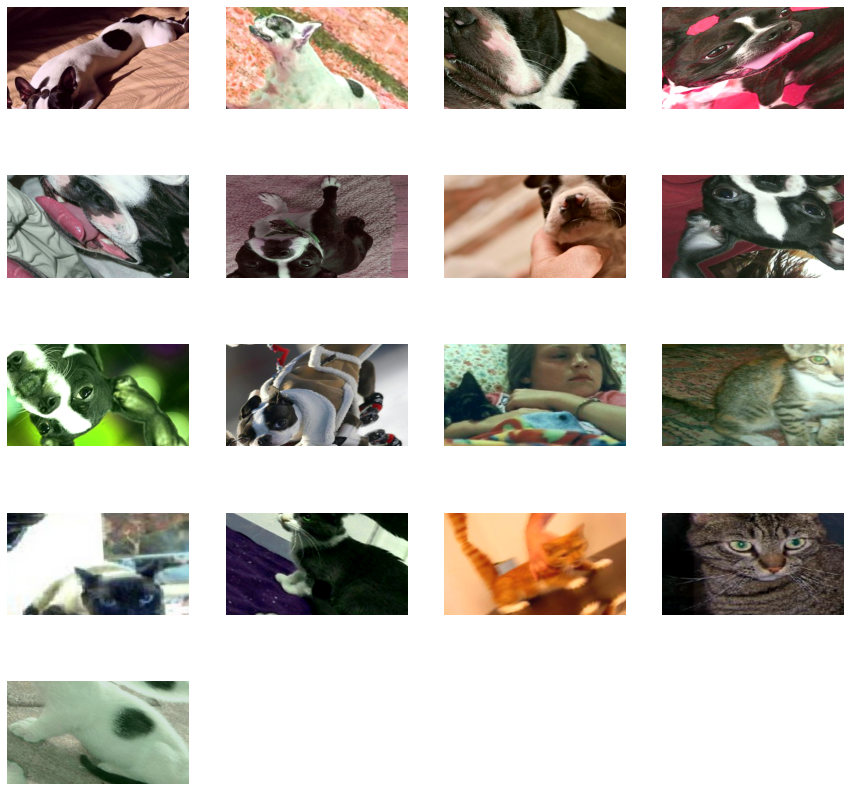

In [99]:
plot_examples(images_list)

### For detection:

In [166]:
image = cv2.imread("dataset/albumentations-ds/cat.jpeg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
bboxes = [[13, 170, 224, 410]]

In [167]:
transform = A.Compose([
    A.Resize(width=1920, height=1080),
    A.RandomCrop(width=1280, height=720),
    A.Rotate(limit=40, p=0.9), # limit in degrees
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.1),
    A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.9),
    A.OneOf([
        A.Blur(blur_limit=3, p=0.5),
        A.ColorJitter(p=0.5),
    ], p=1.0), # one of the transformation is gonna be chosen with a certain probability
    ],
    bbox_params=A.BboxParams(format="pascal_voc",
                             min_area=2048, # the bbox has to have at least 2048 pixels
                             min_visibility=0.3,
                             label_fields=[])

)

In [168]:
images_list = [image]
saved_bboxes = [bboxes[0]]

In [169]:
for i in range(20):
    augmentations = transform(image=image, bboxes=bboxes)

    if len(augmentations["bboxes"]) == 0:
        # The bbox was drop (maybe because it didn't satisfy the min area or the min visibility)
        continue
    images_list.append(augmentations["image"])
    saved_bboxes.append(augmentations["bboxes"][0])

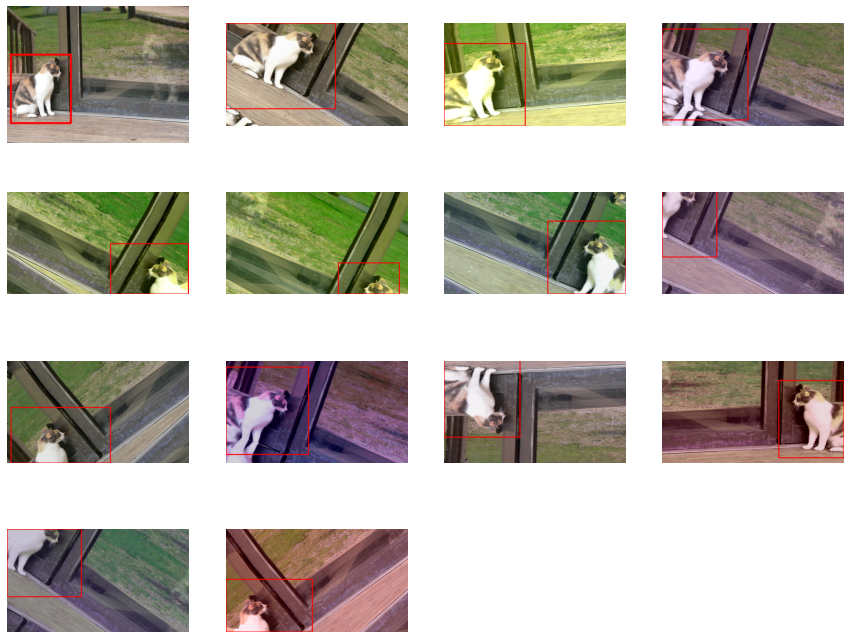

In [170]:
plot_examples(images_list, saved_bboxes)

### For segmentation

Albumentations, instead of torchvision, helps us to apply the SAME transformation both to the image and to the mask!

And even if we have multiple masks, it'll work 🥳

In [114]:
image = Image.open("dataset/albumentations-ds/elon.jpeg")
mask = Image.open("dataset/albumentations-ds/mask.jpeg")
mask2 = Image.open("dataset/albumentations-ds/second_mask.jpeg")

In [115]:
transform = A.Compose([
    A.Resize(width=1920, height=1080),
    A.RandomCrop(width=1280, height=720),
    A.Rotate(limit=40, p=0.9), # limit in degrees
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.1),
    A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.9),
    A.OneOf([
        A.Blur(blur_limit=3, p=0.5),
        A.ColorJitter(p=0.5),
    ], p=1.0), # one of the transformation is gonna be chosen with a certain probability
])

In [119]:
images_list = []
image = np.array(image)
mask = np.array(mask)
mask2 = np.array(mask2)

In [120]:
for i in range(7):
    # augmentations = transform(image=image, mask=mask)
    augmentations = transform(image=image, masks=[mask, mask2])
    augmented_img = augmentations["image"]
    # augmented_mask = augmentations["mask"]
    augmented_masks = augmentations["masks"]
    images_list.append(augmented_img)
    # images_list.append(augmented_mask)
    images_list.append(augmented_masks[0])
    images_list.append(augmented_masks[1])

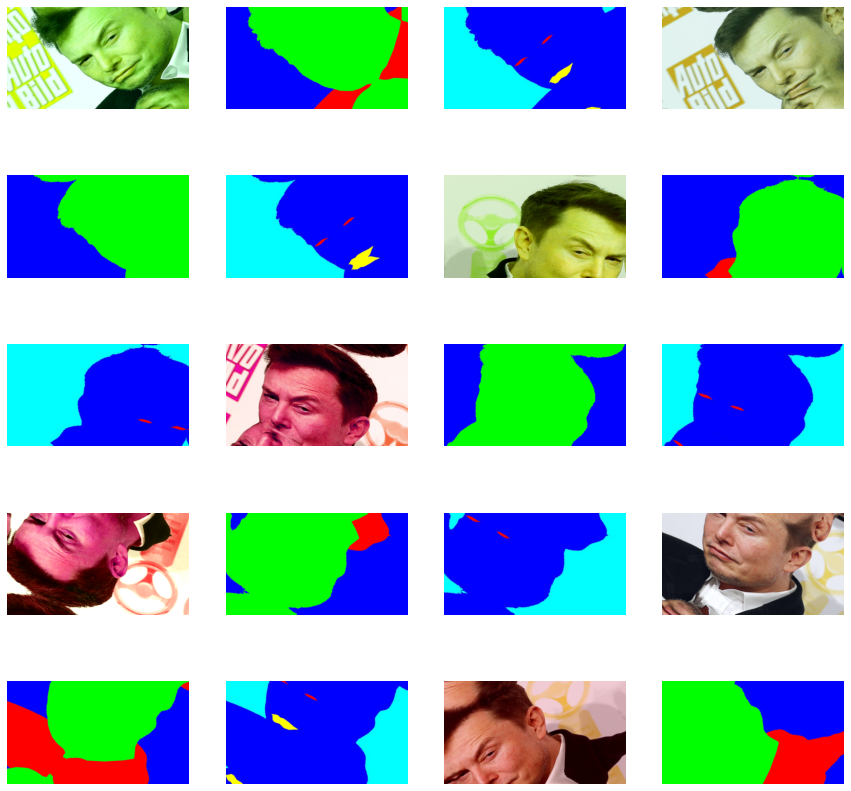

In [121]:
plot_examples(images_list)